### Loading the Data 

In [1]:
import os
from email import policy
import email.parser
from email.parser import BytesParser

In [2]:
def read_data(directory):
    emails = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if not os.path.isfile(filepath):
            continue
        try:
            with open(filepath, "rb") as f:  
                msg = BytesParser(policy=policy.default).parse(f)

                text = None
                if msg.is_multipart():
                    for part in msg.walk():
                        if part.get_content_type() == "text/plain" or part.get_content_type() == "text/html":
                            try:
                                text = part.get_content()
                            except Exception:
                                text = part.get_payload(decode=True).decode("utf-8", errors="ignore")
                            break
                else:
                    try:
                        text = msg.get_content()
                    except Exception:
                        text = msg.get_payload(decode=True).decode("utf-8", errors="ignore")

                if text:
                    emails.append(text.strip())
        except Exception as e:
            print(f"Could not parse {filename}: {e}")
    return emails


In [4]:
os.listdir("../datasets/")

['easy_ham', 'hard_ham', 'spam', 'spam_2']

In [5]:
ham_dirs = ["easy_ham", "hard_ham"]
spam_dirs = ["spam", "spam_2"]
ham_emails = []
spam_emails = []
for f in ham_dirs : 
    ham_emails.extend(read_data(directory=os.path.join("../datasets/",f)))

for f in spam_dirs : 
    spam_emails.extend(read_data(directory=os.path.join("../datasets/",f)))

In [6]:
len(ham_emails) , len(spam_emails)

(2801, 1899)

In [172]:
data_lengths = {"spam" : len(spam_emails), "ham" : len(ham_emails)}

In [173]:
import pandas as pd 

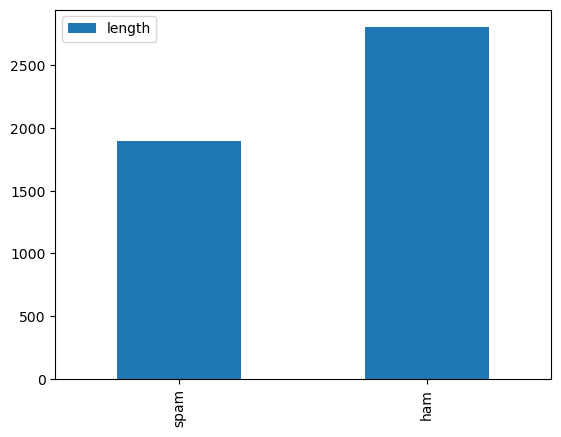

In [175]:
sizes_comparison = pd.DataFrame(data_lengths, index=["length"])
sizes_comparison.T.plot.bar();

### Preprocessing Data 

In [6]:
from bs4 import BeautifulSoup
import re

In [140]:
def normalize_emails (emails) : 
    """
    This method :- 
    1. Strips off any HTML 
    2. Gets rid of the whitespaces, punctuation and unwanted symbols
    3. Converts text to lowercase 
    4. Converts numbers to 'NUMBER'
    5. Converts any links to URLS 
    """
    norm_emails = []
    for content in emails : 
        text = content
        if "<html" in content.lower() or "<!doctype" in content.lower() or "<body" in content.lower() :
            soup = BeautifulSoup(content, "html.parser")
            text = soup.get_text(separator= " ", strip=True)
        text = re.sub(r"http\S+", "URL", text)
        text = re.sub(r"\s+", " ", text).strip()
        text = re.sub(r"\d+", "NUMBER", text)
        text = re.sub(r"[^a-zA-Z\s]", "", text)
        text = text.lower()
        text.replace("number", "NUMBER")
        text.replace("url", "URL")
        norm_emails.append(text)

    return norm_emails    

!pip install nltk

In [131]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import nltk 

nltk.download("punkt")
nltk.download("punkt_tab")  

stemmer = SnowballStemmer("english")

def stem_emails (emails) : 
    """
    Applying the Porter Stemming algorithm to each email in the dataset 
    """
    stemmed_corpus = []
    for text in emails:
        if not isinstance(text, str):
            stemmed_corpus.append("")
            continue
        tokens = word_tokenize(text)
        stems = [stemmer.stem(token) for token in tokens]
        stemmed_corpus.append(" ".join(stems))
    return stemmed_corpus

        

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [203]:
#vecotrizing 
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

def convert_to_feature_vectors(emails) : 
    return vectorizer.fit_transform(emails)

### Writing the pipeline 

In [176]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
import numpy as np 
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [134]:
emails = spam_emails + ham_emails

In [135]:
y = np.ones(len(spam_emails))
y = np.append(y, np.zeros(len(ham_emails)))

In [136]:
X_train, X_test, y_train, y_test = train_test_split(emails, y, shuffle=True)

In [212]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [214]:
norm_transformer = FunctionTransformer(normalize_emails)
stem_transformer = FunctionTransformer(stem_emails)
#vector_transformer = FunctionTransformer(convert_to_feature_vectors)

vectorizer = TfidfVectorizer(
    max_features=40000,   
    ngram_range=(1,2),   
    stop_words='english' 
)

preprocessing = make_pipeline(norm_transformer, stem_transformer, vectorizer)

In [215]:
X_train_f = preprocessing.fit_transform(X_train)

In [216]:
X_test_f = preprocessing.transform(X_test)

In [217]:
X_test_f.shape[1] == X_train_f.shape[1]

True

In [143]:
type(X_train_f)

scipy.sparse._csr.csr_matrix

## Training the model (SGD)

In [221]:
from sklearn.model_selection import cross_val_score

In [222]:
sgd_clf = SGDClassifier(random_state=42)
cross_val_score(sgd_clf, X_train_f, y_train, scoring="f1", cv=3)

array([0.97717842, 0.97650664, 0.97319588])

In [234]:
param_grid_sgd = {
    'loss': ['hinge', 'log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2],   # try 3 levels
    'max_iter': [1000],            # fixed, let it converge
    'learning_rate': ['optimal'],  # safe default
}


rnd_search_sgd = RandomizedSearchCV(
    sgd_clf,
    param_distributions=param_grid_sgd,
    n_iter=30,     
    cv=3,          
    scoring="f1",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rnd_search_sgd.fit(X_train_f, y_train)

C:\Users\ADMIN\anaconda3\envs\spam_classifier\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=30. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 27 candidates, totalling 81 fits


,estimator,SGDClassifier(random_state=42)
,param_distributions,"{'alpha': [0.0001, 0.001, ...], 'learning_rate': ['optimal'], 'loss': ['hinge', 'log_loss', ...], 'max_iter': [1000], ...}"
,n_iter,30
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [235]:
best_sgd = rnd_search.best_estimator_

In [237]:
cross_val_score(best_sgd, X_train_f, y_train, cv=3, scoring="f1")

array([0.97540984, 0.97560976, 0.97119342])

In [240]:
preds_best_sgd = best_sgd.predict(X_test_f)
print(classification_report(y_test, preds_best_sgd))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       739
         1.0       0.96      0.97      0.96       436

    accuracy                           0.97      1175
   macro avg       0.97      0.97      0.97      1175
weighted avg       0.97      0.97      0.97      1175



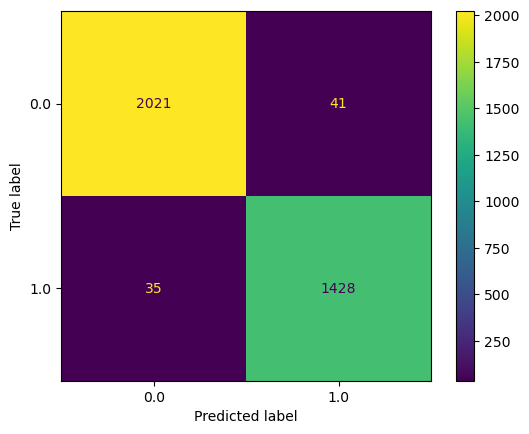

In [241]:
y_train_pred = cross_val_predict(best_sgd, X_train_f, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

### Normalizing the confusion matrix

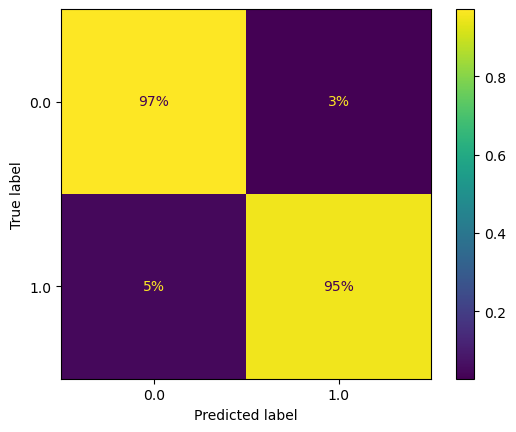

In [178]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

In [180]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      2062
         1.0       0.96      0.95      0.96      1463

    accuracy                           0.96      3525
   macro avg       0.96      0.96      0.96      3525
weighted avg       0.96      0.96      0.96      3525



In [183]:
#pinpointing the exact threshold at 96% precision (or at 96% f1 score)
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(y_train, sgd_y_scores)
idx_for_96_precision_sgd = (precisions_sgd >= 0.96).argmax()
threshold_for_96_precision_sgd = thresholds_sgd[idx_for_96_precision_sgd]
threshold_for_96_precision_sgd

np.float64(-0.21252730676765008)

In [185]:
precisions_sgd[idx_for_96_precision_sgd]

np.float64(0.9601374570446736)

## Model #2 : Random Forest 

In [224]:
from sklearn.ensemble import RandomForestClassifier

In [225]:
rf_clf = RandomForestClassifier(random_state=42)

In [226]:
cross_val_score(rf_clf, X_train_f, y_train, scoring="f1", cv=3)

array([0.97154472, 0.96793587, 0.9667003 ])

In [227]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [100, 300, 500],          
    "max_depth": [None, 10, 20, 50],          
    "min_samples_split": [2, 5, 10],          
    "min_samples_leaf": [1, 2, 5],            
    "max_features": ["sqrt", "log2"],         
    "class_weight": [None, "balanced"]        
}

rnd_search = RandomizedSearchCV(
    rf_clf,
    param_distributions=param_grid,
    n_iter=30,     
    cv=3,          
    scoring="f1",
    n_jobs=-1,
    verbose=2,
    random_state=42
)
rnd_search.fit(X_train_f, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'class_weight': [None, 'balanced'], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,30
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [228]:
best_rf_clf = rnd_search.best_estimator_
cross_val_score(best_rf_clf, X_train_f, y_train, cv=3, scoring="f1")

array([0.97540984, 0.97560976, 0.97119342])

In [229]:
preds_rf = best_rf_clf.predict(X_test_f)

In [231]:
print(classification_report(y_test, preds_rf))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       739
         1.0       0.96      0.97      0.96       436

    accuracy                           0.97      1175
   macro avg       0.97      0.97      0.97      1175
weighted avg       0.97      0.97      0.97      1175



### Comparing Models

In [242]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [243]:
sgd_y_scores = cross_val_predict(sgd_clf, X_train_f, y_train, cv=3, method="decision_function")

In [244]:
sgd_y_scores[:5]

array([-2.04422198, -1.49245093, -1.33152114,  1.08301747, -1.08873409])

In [245]:
rf_y_scores = cross_val_predict(best_rf_clf, X_train_f, y_train, cv=3, method="predict_proba")

In [246]:
rf_y_scores[:5]

array([[0.97598999, 0.02401001],
       [0.90073844, 0.09926156],
       [0.94089324, 0.05910676],
       [0.32743677, 0.67256323],
       [0.94891012, 0.05108988]])

In [247]:
y_scores_forest = rf_y_scores[:,1]

In [248]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train, y_scores_forest)

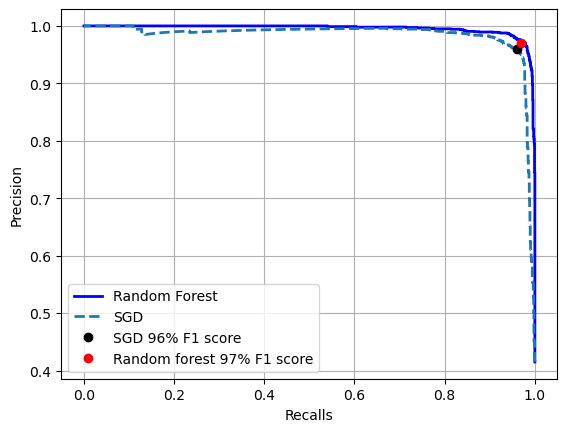

In [252]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls_sgd, precisions_sgd, "--", linewidth=2, label="SGD")
plt.plot(0.96, 0.96, "ko", label="SGD 96% F1 score")
plt.plot(0.97, 0.97, "ro", label="Random forest 97% F1 score")
plt.legend()
plt.grid(visible=True)
plt.xlabel("Recalls")
plt.ylabel("Precision")
plt.show()